# Fitting of ΔGs

In [1]:
import matplotlib.pyplot as plt
from pyhdx import PeptideMasterTable, read_dynamx, HDXMeasurement
from pyhdx.fitting import fit_rates_half_time_interpolate, fit_rates_weighted_average, fit_gibbs_global
from pathlib import Path
import numpy as np
from dask.distributed import Client

We load the sample SecB dataset, apply the control, and create an ``HDXMeasurement`` object.

In [2]:
fpath = Path() / '..' / '..' / 'tests' / 'test_data' / 'ecSecB_apo.csv'
data = read_dynamx(fpath)
master_table = PeptideMasterTable(data, drop_first=1, ignore_prolines=True)
master_table.set_control(('Full deuteration control', 0.167))
state_data = master_table.get_state('SecB WT apo')
hdxm = HDXMeasurement(state_data, temperature=303.15, pH=8.)

The first step is to obtain initial guesses for the observed rate of D-exchange.
By determining the timepoint at which 0.5 RFU (relative fractional uptake) is reached, and subsequently converting to rate,
a rough estimate of exchange rate per residue can be obtained. Here, RFU values are mapped from peptides to individual
residues by weighted averaging (where the weight is the inverse of peptide length)

In [3]:
fr_half_time = fit_rates_half_time_interpolate(hdxm)
fr_half_time.output

C:\Users\jhsmi\pp\PyHDX\pyhdx\models.py:615: RuntimeWarning: invalid value encountered in true_divide
  return self.Z / np.sum(self.Z, axis=0)[np.newaxis, :]


,rate
r_number,
10,3.267322
11,3.267322
12,2.118046
13,2.118046
14,2.118046
...,...
151,8.196291
152,8.187618
153,8.187618


A more accurate result can be obtained by fitting the per-residue/timepoint RFU values to a biexponential association curve.
This process is more time consuming and can optionally be processed in parallel by Dask.

In [4]:
client = Client()
fr_wt_avg = fit_rates_weighted_average(hdxm, client=client)

C:\Users\jhsmi\pp\PyHDX\pyhdx\models.py:615: RuntimeWarning: invalid value encountered in true_divide
  return self.Z / np.sum(self.Z, axis=0)[np.newaxis, :]


The return value is a ``KineticsFitResult`` object. This object has a list of models, intervals in withing the protein 
sequence to which these models apply, and their corresponding ``symfit`` fit result with parameter values. The effective 
exchange rate can be extracted, as well as other fit parameters, from this object:

In [5]:
fr_wt_avg.output

,rate,k1,k2,r
r_number,,,,
10,3.870799,11.254070,0.088882,0.569039
11,3.870799,11.254070,0.088882,0.569039
12,3.305989,11.469306,0.094220,0.539730
13,3.305989,11.469306,0.094220,0.539730
14,3.305989,11.469306,0.094220,0.539730
...,...,...,...,...
151,182.177197,2.959920,187.037448,0.018397
152,76.881199,83.062667,7.501664,0.941298
153,76.881199,83.062667,7.501664,0.941298


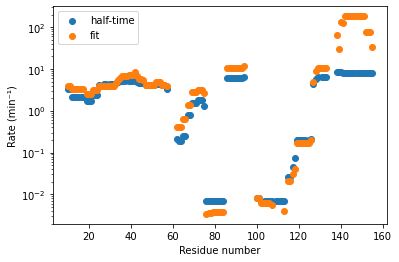

In [6]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.scatter(fr_half_time.output.index, fr_half_time.output['rate'], label='half-time')
ax.scatter(fr_wt_avg.output.index, fr_wt_avg.output['rate'], label='fit')

ax.set_xlabel('Residue number')
ax.set_ylabel('Rate (min⁻¹)')
ax.legend()


We can now use the guessed rates to obtain guesses for the Gibbs free energy. Units of Gibbs free energy are J/mol.

In [7]:
gibbs_guess = hdxm.guess_deltaG(fr_wt_avg.output['rate'])
gibbs_guess

r_number
10     19771.172125
11     19306.673568
12     20633.307571
13     16858.446171
14     18949.558074
           ...     
151     8231.449509
152    11043.795062
153    13458.866307
154    13737.722831
155     1404.241871
Length: 146, dtype: float64

To perform the global fit (all peptides and timepoints) use ``fit_gibbs_global``. The number of epochs is set to 1000
here for demonstration but for actually fitting the values should be ~100000.

In [8]:
gibbs_result = fit_gibbs_global(hdxm, gibbs_guess, epochs=1000)
gibbs_output = gibbs_result.output
gibbs_output

100%|██████████| 1000/1000 [00:00<00:00, 1311.64it/s]


,sequence,_deltaG,deltaG,pfact,k_obs,covariance
r_number,,,,,,
10,T,19780.436107,19780.436107,2559.919111,3.856604,2.957820e+04
11,F,19357.657675,19357.657675,2164.613179,3.793324,2.946089e+04
12,Q,20664.140121,20664.140121,3634.887678,3.265806,1.650350e+04
13,I,16945.272519,16945.272519,831.226484,3.194180,1.640756e+04
14,Q,19008.401110,19008.401110,1884.527086,3.229744,1.645134e+04
...,...,...,...,...,...,...
151,E,8259.021923,8259.021923,26.488253,180.267300,3.521129e+09
152,H,11043.796744,11043.796744,79.960971,76.881149,1.599581e+06
153,Q,13458.868002,13458.868002,208.449957,76.881148,1.587919e+06


Along with ΔG the fit result returns covariances of ΔG and protection factors. The column `k_obs` is the observed rate of
exchange without taking into account the intrinsic exchange rate of each residue. If users want to obtain a result truly
independent of the intrinsic rate of exchange, the regularization value r1 should be set to zero (as this works on ΔG,
which is obtained by taking intrinsic rate of exchange into account) and users should provide their own initial guesses
for ΔG (as determination of initial guesses also uses intrinsic rates of exchange).

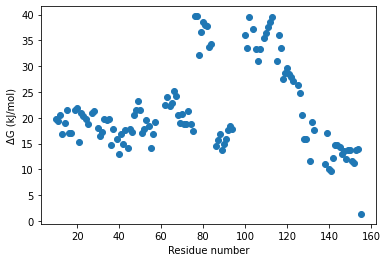

In [11]:
fig, ax = plt.subplots()
#ax.set_yscale('log')
ax.scatter(gibbs_output.index, gibbs_output['deltaG']*1e-3)
ax.set_xlabel('Residue number')
ax.set_ylabel('ΔG (kJ/mol)')
None


The returned fit result object also has information on the losses of each epoch of the fittng process. These are
stored as a `pd.DataFrame` in the `losses` attribute. During a successful fitting run, the losses should decline and
then plateau as the fit converged.

<AxesSubplot:xlabel='epoch'>

<Figure size 432x288 with 0 Axes>

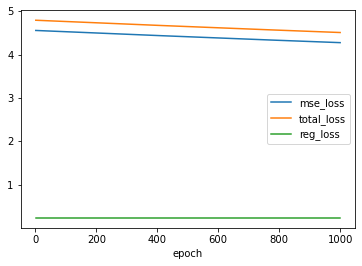

In [9]:
plt.figure()
gibbs_result.losses[['mse_loss', 'total_loss', 'reg_loss']].plot()

In the figure above, `mse_loss` is the loss resulting from differences in calculated D-uptake and measured D-uptake
(mean squared error). The `reg_loss` are losses resulting from the regualizer.

If the losses do not decrease, this is likely due to a too low number of epochs or a too low learning rate. If the
losses do not plateau, more epochs are required, or the fitting stop condition needs to be tweaked by
Lets tune the fit parameters such that we obtain the desired result.

In [10]:
gibbs_result_updated = fit_gibbs_global(hdxm, gibbs_guess, epochs=40000)

100%|██████████| 40000/40000 [00:28<00:00, 1385.19it/s]


Text(0, 0.5, 'Loss')

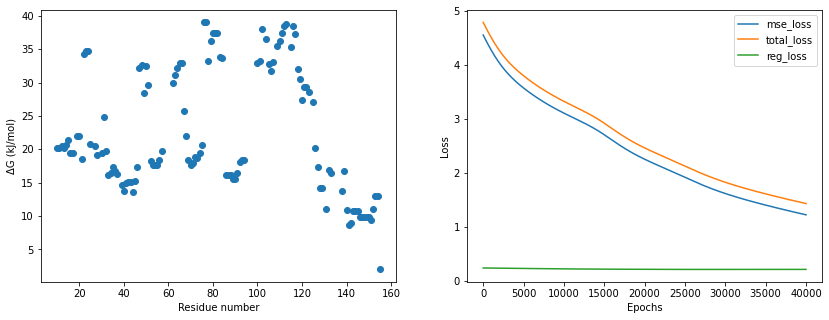

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
axes[0].scatter(gibbs_result_updated.output.index, gibbs_result_updated.output['deltaG']*1e-3)
axes[0].set_xlabel('Residue number')
axes[0].set_ylabel('ΔG (kJ/mol)')
gibbs_result_updated.losses[['mse_loss', 'total_loss', 'reg_loss']].plot(ax=axes[1])
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')

By increasing the learning rate and the number of epochs, our result improves as the final MSE loss is lower.

With `stop_loss` at 1E-6 and `patience` at 50 (=default), the fitting will not terminate until for 50
epochs the progress (loss decrease) has been less than 1E-6.

In [12]:
gibbs_result_updated = fit_gibbs_global(hdxm, gibbs_guess, epochs=60000, lr=1e5, stop_loss=1e-6, patience=50)


100%|██████████| 60000/60000 [00:46<00:00, 1295.91it/s]


In [34]:
gibbs_result_updated.regularization_percentage

55.70539624555

Text(0, 0.5, 'Loss')

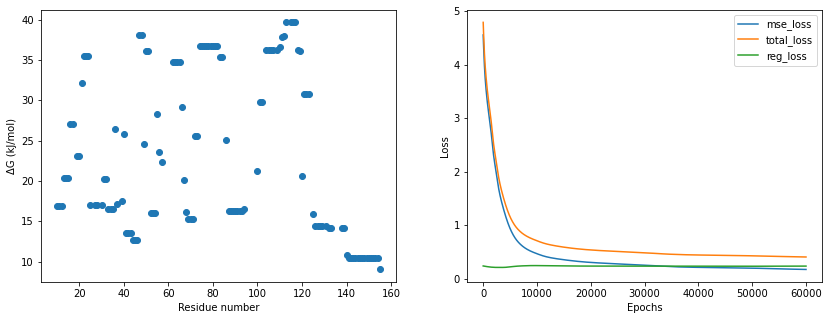

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
axes[0].scatter(gibbs_result_updated.output.index, gibbs_result_updated.output['deltaG']*1e-3)
axes[0].set_xlabel('Residue number')
axes[0].set_ylabel('ΔG (kJ/mol)')
gibbs_result_updated.losses[['mse_loss', 'total_loss', 'reg_loss']].plot(ax=axes[1])
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')

#### The choice of regularizer value r1

The regularizer `r1` acts between subsequent residues minimizing differences between residues, unless data support
these differences. Higher values flatten out the ΔG values along residues, while lower values allow for more
variability.

The main function of `r1` is to mitigate the non-identifiability problem, where if multiple effective exchange rates (ΔG)
values are found within a peptide, it is impossible to know which rate should be assigned to which residue. Among the
possible choices, the regularizer `r1` will bias the result towards the choice of rate per residue assignment with the
least variability along residues.

The 'best' value of r1 depends on the size of the protein and the coverage, (the number/size of peptides). Below is an
example of the differences with regularizer values 0, 0.01 and 1 (=default).
In this dataset, despite the fact that for `r1=0.1` contribution `reg_loss` is 50% of `total_loss`, the results are
mostly the same. For `r1=0.1` we see some slight damping (lower extreme ΔG) values with respect to lower values of `r1`

In [14]:
r1_vals = [0., 0.1, 1]
results_dict = {}
for r1 in r1_vals:
    print(r1)
    result = fit_gibbs_global(hdxm, gibbs_guess, epochs=60000, lr=1e5, stop_loss=1e-6, patience=50, r1=r1)
    results_dict[r1] = result

100%|██████████| 60000/60000 [00:46<00:00, 1282.78it/s]


0.0
0.1
1


0.0
22.880811923361012
57.75651016662992


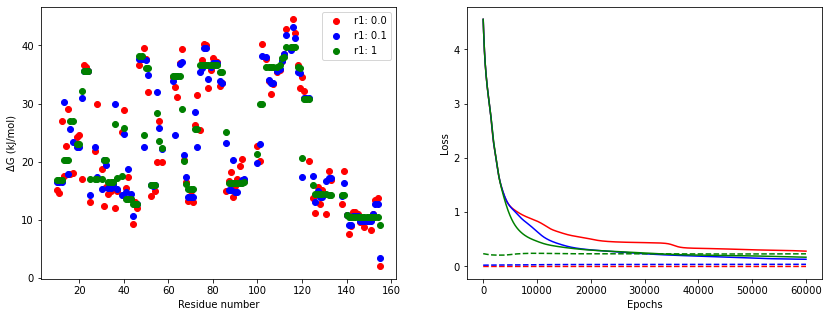

In [15]:
colors = iter(['r', 'b', 'g'])
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
for k, v in results_dict.items():
    print(v.regularization_percentage)
    color = next(colors)
    axes[0].scatter(v.output.index, v.output['deltaG']*1e-3, color=color, label=f'r1: {k}')
    axes[0].set_xlabel('Residue number')
    axes[0].set_ylabel('ΔG (kJ/mol)')
    axes[1].plot(v.losses['mse_loss'], color=color)
    axes[1].plot(v.losses['reg_loss'], color=color, linestyle='--')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')

axes[0].legend()